<a href="https://colab.research.google.com/github/Sumya-Oishe/Adjoint-Opt/blob/main/Ceviche_0_1_2_Differentiator100iterations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install ceviche

  Preparing metadata (setup.py) ... done
  Created wheel for pyMKL: filename=pyMKL-0.0.3-py3-none-any.whl size=6743 sha256=376b3a6074848441b7d0987be7e135389dac53454c6cf58d294ca0d60693af96
  Stored in directory: /root/.cache/pip/wheels/a2/ce/28/e96ecd42560071a93084965f0200e301569f4e0740d0c4df6b
Successfully built pyMKL


In [ ]:
import numpy as np
import autograd.numpy as npa
from scipy import interpolate
import copy

import matplotlib as mpl
mpl.rcParams['figure.dpi']=100

import matplotlib.pylab as plt

from autograd.scipy.signal import convolve as conv
from skimage.draw import disk

import ceviche
from ceviche import fdfd_ez, jacobian
from ceviche.optimizers import adam_optimize
from ceviche.modes import insert_mode

import collections
# Create a container for our slice coords to be used for sources and probes
Slice = collections.namedtuple('Slice', 'x y')

In [ ]:
from keras.datasets import mnist     # MNIST dataset is included in Keras
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel images
(EpsX_train, y_train), (EpsX_test, y_test) = mnist.load_data()
EpsX_train.shape, y_train.shape, EpsX_test.shape, y_test.shape

11490434/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

<ipython-input-4-70a3db96ca7e>:19: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f0 = interpolate.interp2d(xA, yA, EpsX_train[iindex0,:,:]/256.0, kind='cubic')
<ipython-input-4-70a3db96ca7e>:20: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridI

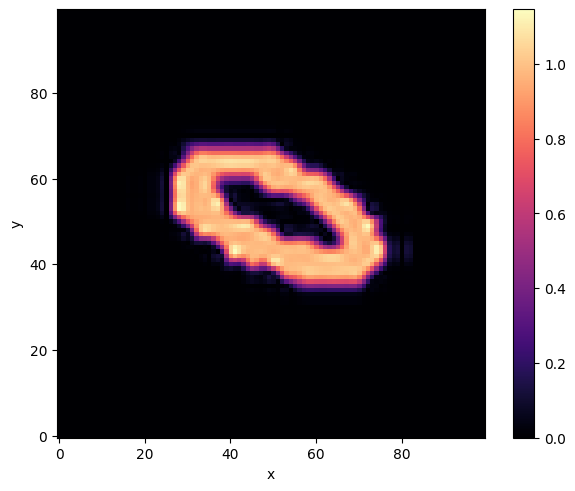

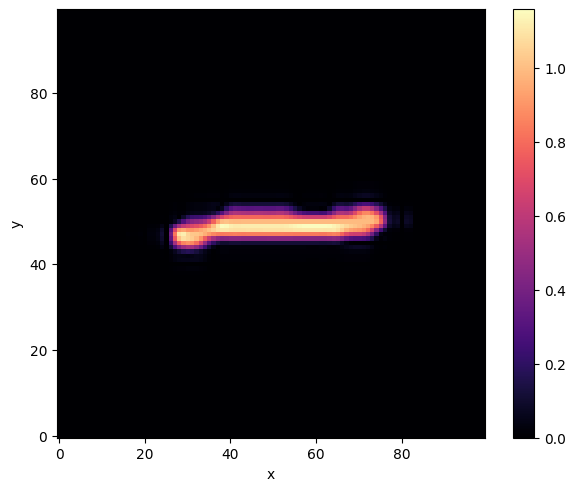

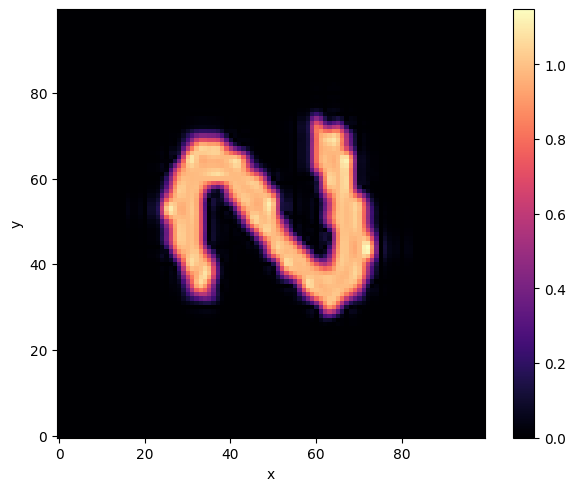

In [ ]:
Nx = 100
Ny = 100
Nx_half = Nx//2
Ny_half = Ny//2

iindex0 = 34           # 34 is zero
iindex1 = 14           # 14 is one
iindex2 = 25           # 25 is two
#iindex3 = 27           # 27 is three


# if we want to enlarge the figure size, then do something like this
xA = np.arange(0,28)
yA = np.arange(0,28)

xi = np.arange(0,28,0.4)
yi = np.arange(0,28,0.4)

f0 = interpolate.interp2d(xA, yA, EpsX_train[iindex0,:,:]/256.0, kind='cubic')
f1 = interpolate.interp2d(xA, yA, EpsX_train[iindex1,:,:]/256.0, kind='cubic')
f2 = interpolate.interp2d(xA, yA, EpsX_train[iindex2,:,:]/256.0, kind='cubic')

zi0 = f0(xi, yi)
zi1 = f1(xi, yi)
zi2 = f2(xi, yi)

Npixel = len(xi)
Npixel_half = Npixel//2

epsr0 = np.zeros((Nx, Ny))
epsr1 = np.zeros((Nx, Ny))
epsr2 = np.zeros((Nx, Ny))

epsr0[Nx_half-Npixel_half:Nx_half+Npixel_half,Ny_half-Npixel_half:Ny_half+Npixel_half] = zi0
epsr1[Nx_half-Npixel_half:Nx_half+Npixel_half,Ny_half-Npixel_half:Ny_half+Npixel_half] = zi1
epsr2[Nx_half-Npixel_half:Nx_half+Npixel_half,Ny_half-Npixel_half:Ny_half+Npixel_half] = zi2

ax = ceviche.viz.abs(epsr0, cbar=True);
plt.show()

ax = ceviche.viz.abs(epsr1, cbar=True);
plt.show()

ax = ceviche.viz.abs(epsr2, cbar=True);
plt.show()


In [ ]:
len(xi)

70

In [ ]:
# The angular frequency
omega1=2*np.pi*5e14
# Spatial resolution in meters
dl=10e-9
# Number of pixels in x-direction
Nx=500
# Number of pixels in y-direction
Ny=500
# Number of pixels in the PMLs in each direction
Npml=40
# Minimum value of the relative permittivity
epsr_min=1.0
# Maximum value of the relative permittivity
epsr_max=12.0
# Radius of the smoothening features
blur_radius=2
# Number of times to apply the blur
N_blur=1
# Strength of the binarizing projection
beta=10.0
# Middle point of the binarizing projection
eta=0.5
# Number of times to apply the blur
N_proj=1
# Space between the PMLs and the design region (in pixels)
space=80
# Width of the waveguide (in pixels)
wg_width=50
# Length in pixels of the source/probe slices on each side of the center point
space_slice=16

# Number of epochs in the optimization
Nsteps=100
# Step size for the Adam optimizer
step_size=1e-3

In [ ]:
# Projection that drives rho towards a "binarized" design with values either 0 or 1
def operator_proj(rho, eta=0.5, beta=100, N=1):
    """Density projection
    eta     : Center of the projection between 0 and 1
    beta    : Strength of the projection
    N       : Number of times to apply the projection
    """
    for i in range(N):
        rho =  npa.divide(npa.tanh(beta * eta) + npa.tanh(beta * (rho - eta)),
                          npa.tanh(beta * eta) + npa.tanh(beta * (1 - eta)))

    return rho

# Blurring filter that results in smooth features of the structure
# First we define a function to create the kernel
def _create_blur_kernel(radius,Nshape):
    """Helper function used below for creating the conv kernel"""
    rr, cc = rr, cc = disk((radius, radius), radius+1, shape=(Nshape, Nshape))
    kernel = np.zeros((2*radius+1, 2*radius+1), dtype=float)
    kernel[rr, cc] = 1
    return  kernel/kernel.sum()

# Then we define the function to apply the operation
def operator_blur(rho, radius=2, N=1, Nshape=50):
    """Blur operator implemented via two-dimensional convolution
    radius    : Radius of the circle for the conv kernel filter
    N         : Number of times to apply the filter

    Note that depending on the radius, the kernel is not always a
    perfect circle due to "pixelation" / stair casing
    """

    kernel = _create_blur_kernel(radius, Nshape)

    for i in range(N):
        # For whatever reason HIPS autograd doesn't support 'same' mode, so we need to manually crop the output
        rho = conv(rho, kernel, mode='full')[radius:-radius,radius:-radius]

    return rho

def viz_sim(epsr0, epsr1, epsr2, source0, source1, source2, slices=[]):
    """Solve and visualize a simulation with permittivity 'epsr'"""
    simulation1 = fdfd_ez(omega1, dl, epsr0, [Npml, Npml])
    _, _, Ez1 = simulation1.solve(source0)
    simulation2 = fdfd_ez(omega1, dl, epsr1, [Npml, Npml])
    _, _, Ez2 = simulation2.solve(source1)
    simulation3 = fdfd_ez(omega1, dl, epsr2, [Npml, Npml])
    _, _, Ez3 = simulation3.solve(source2)

    fig, ax = plt.subplots(2, 3, constrained_layout=True, figsize=(12,8))
    ceviche.viz.abs(Ez1, outline=epsr0, ax=ax[0,0], cbar=False)
    ceviche.viz.abs(Ez2, outline=epsr1, ax=ax[0,1], cbar=False)
    ceviche.viz.abs(Ez3, outline=epsr2, ax=ax[0,2], cbar=False)
    ceviche.viz.abs(epsr0, ax=ax[1,0], cmap='Greys')
    ceviche.viz.abs(epsr1, ax=ax[1,1], cmap='Greys')
    ceviche.viz.abs(epsr2, ax=ax[1,2], cmap='Greys')

    for sl in slices:
        ax[0,0].plot(sl.x*np.ones(len(sl.y)), sl.y, 'w-', alpha=0.5)
        ax[0,1].plot(sl.x*np.ones(len(sl.y)), sl.y, 'w-', alpha=0.5)
        ax[0,2].plot(sl.x*np.ones(len(sl.y)), sl.y, 'w-', alpha=0.5)

    ax[0,0].set_title('Ez for epsr0')
    ax[0,1].set_title('Ez for epsr1')
    ax[0,2].set_title('Ez for epsr2')
    ax[1,0].set_title('epsr0')
    ax[1,1].set_title('epsr1')
    ax[1,2].set_title('epsr2')

    return (simulation1, simulation2, simulation3, ax, fig)


def mask_combine_rho(rho, bg_rho, design_region):
    """Utility function for combining the design region rho and the background rho
    """
    return rho*design_region + bg_rho*(design_region==0).astype(float)

def epsr_parameterization(rho, bg_rho, design_region, radius=2, N_blur=1, beta=100, eta=0.5, N_proj=1):
    """Defines the parameterization steps for constructing rho
    """
    # Combine rho and bg_rho; Note: this is so the subsequent blur sees the waveguides
    rho = mask_combine_rho(rho, bg_rho, design_region)

    rho = operator_blur(rho, radius=radius, N=N_blur)
    rho = operator_proj(rho, beta=beta, eta=eta, N=N_proj)

    # Final masking undoes the blurring of the waveguides
    rho = mask_combine_rho(rho, bg_rho, design_region)

    return epsr_min + (epsr_max-epsr_min) * rho

## Simulate the initial structure (by me)



In [ ]:
def init_domain(zi0, zi1, zi2, Nx, Ny, Npml, space=80, wg_width=50, space_slice=16, wg_shift=9):
    """Initializes the domain and design region"""
    rho = np.zeros((Nx, Ny))
    bg_rho0 = np.zeros((Nx, Ny))
    bg_rho1 = np.zeros((Nx, Ny))
    bg_rho2 = np.zeros((Nx, Ny))

    design_region = np.zeros((Nx, Ny))

    # Input waveguide
    bg_rho0[0:Npml+space, Ny//2-wg_width//2:Ny//2+wg_width//2] = 1
    bg_rho1[0:Npml+space, Ny//2-wg_width//2:Ny//2+wg_width//2] = 1
    bg_rho2[0:Npml+space, Ny//2-wg_width//2:Ny//2+wg_width//2] = 1

    bg_rho0[Npml+space-Npixel:Npml+space, Ny//2-Npixel//2:Ny//2+Npixel//2] = zi0
    bg_rho1[Npml+space-Npixel:Npml+space, Ny//2-Npixel//2:Ny//2+Npixel//2] = zi1
    bg_rho2[Npml+space-Npixel:Npml+space, Ny//2-Npixel//2:Ny//2+Npixel//2] = zi2

    # Input probe slice
    input_slice = Slice(x=np.array(Npml+1),
        y=np.arange(Ny//2-wg_width//2-space_slice, Ny//2+wg_width//2+space_slice))

    # Output waveguide 1
    bg_rho0[int(Nx-Npml-space)::, Npml+space+wg_shift:Npml+space+wg_width+wg_shift] = 1
    bg_rho1[int(Nx-Npml-space)::, Npml+space+wg_shift:Npml+space+wg_width+wg_shift] = 1
    bg_rho2[int(Nx-Npml-space)::, Npml+space+wg_shift:Npml+space+wg_width+wg_shift] = 1

    # Output waveguide 2
    bg_rho0[int(Nx-Npml-space)::, Ny-Npml-space-wg_width-wg_shift:Ny-Npml-space-wg_shift] = 1
    bg_rho1[int(Nx-Npml-space)::, Ny-Npml-space-wg_width-wg_shift:Ny-Npml-space-wg_shift] = 1
    bg_rho2[int(Nx-Npml-space)::, Ny-Npml-space-wg_width-wg_shift:Ny-Npml-space-wg_shift] = 1

    # Output waveguide 3
    bg_rho0[int(Nx-Npml-space)::, Ny//2-wg_width//2:Ny//2+wg_width//2] = 1
    bg_rho1[int(Nx-Npml-space)::, Ny//2-wg_width//2:Ny//2+wg_width//2] = 1
    bg_rho2[int(Nx-Npml-space)::, Ny//2-wg_width//2:Ny//2+wg_width//2] = 1

    # Output probe slice 1
    output_slice1 = Slice(x=np.array(Nx-Npml-1),
        y=np.arange(Npml+space-space_slice+wg_shift, Npml+space+wg_width+space_slice+wg_shift))

    # Output probe slice 2
    output_slice2 = Slice(x=np.array(Nx-Npml-1),
        y=np.arange(Ny-Npml-space-wg_width-wg_shift-space_slice, Ny-Npml-space-wg_shift+space_slice))

    # Output probe slice 3
    output_slice3 = Slice(x=np.array(Nx-Npml-1),
        y=np.arange(Ny//2-wg_width//2-space_slice, Ny//2+wg_width//2+space_slice))

    design_region[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space] = 1

    # Constant initialization
    rho = design_region * 0.5

    return rho, bg_rho0, bg_rho1, bg_rho2, design_region, input_slice, output_slice1, output_slice2, output_slice3


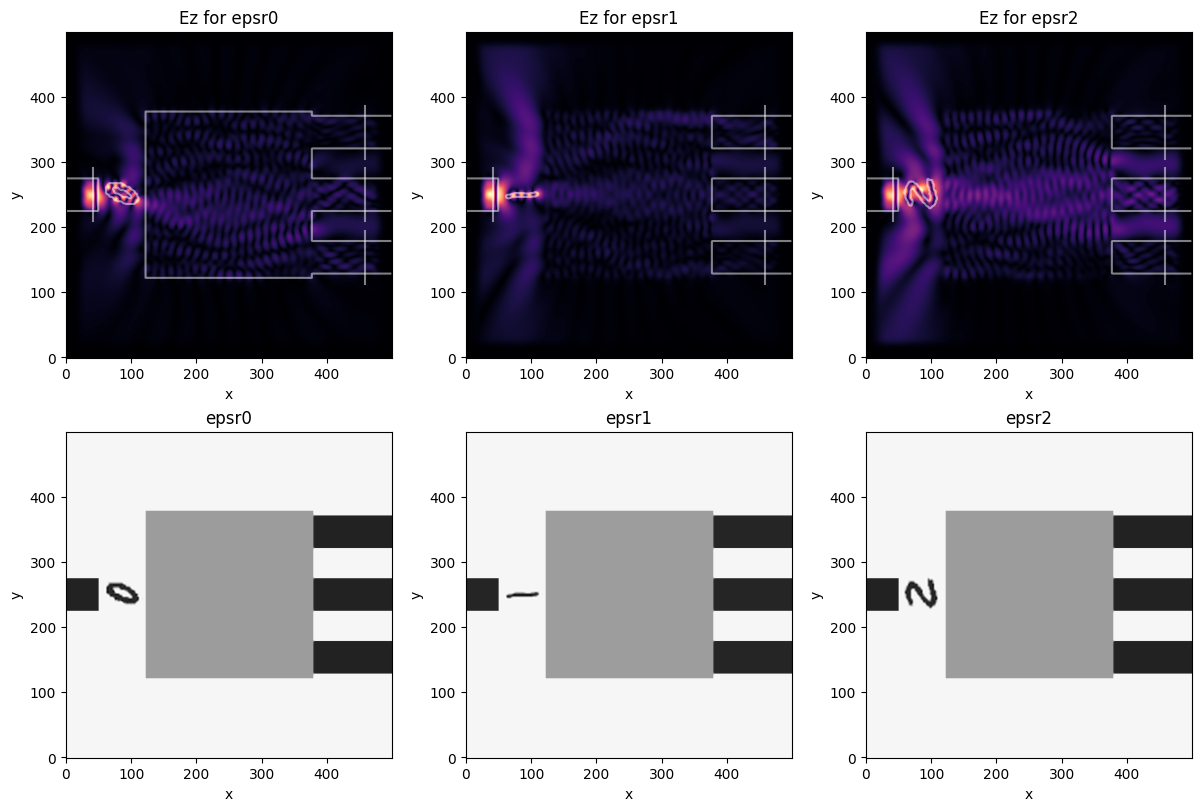

In [ ]:
# Initialize the domain
rho, bg_rho0, bg_rho1, bg_rho2, design_region, input_slice, output_slice1, output_slice2, output_slice3 = init_domain(
    zi0, zi1, zi2, Nx, Ny, Npml, space=80, wg_width=50, space_slice=16, wg_shift=9)

# Compute the permittivity from rho_init, including blurring and projection
epsr_init0 = epsr_parameterization(rho, bg_rho0, design_region, \
                                  radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)
epsr_init1 = epsr_parameterization(rho, bg_rho1, design_region, \
                                  radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)
epsr_init2 = epsr_parameterization(rho, bg_rho2, design_region, \
                                  radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)

# Setup sources
source0 = insert_mode(omega1, dl, input_slice.x, input_slice.y, epsr_init0, m=1)
source1 = insert_mode(omega1, dl, input_slice.x, input_slice.y, epsr_init1, m=1)
source2 = insert_mode(omega1, dl, input_slice.x, input_slice.y, epsr_init2, m=1)

# Setup probes
probe1 = insert_mode(omega1, dl, output_slice1.x, output_slice1.y, epsr_init0, m=1)
probe2 = insert_mode(omega1, dl, output_slice2.x, output_slice2.y, epsr_init1, m=1)
probe3 = insert_mode(omega1, dl, output_slice3.x, output_slice3.y, epsr_init2, m=1)

# Simulate initial device
simulation1, simulation2, simulation3, ax, fig = viz_sim(epsr_init0, epsr_init1, epsr_init2, source0, source1, source2, slices=[input_slice, output_slice1, output_slice2, output_slice3])


In [ ]:
!mkdir tmp

In [ ]:
def callback_output_structure(iteration, of_list, rho):
    """Callback function to output fields and the structures (for making sweet gifs)"""
    rho = rho.reshape((Nx, Ny))
    epsr0 = epsr_parameterization(rho, bg_rho0, design_region, \
                                  radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)
    epsr1 = epsr_parameterization(rho, bg_rho1, design_region, \
                                  radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)
    epsr2 = epsr_parameterization(rho, bg_rho2, design_region, \
                                  radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)

    (simulation1, simulation2, simulation3, ax, fig) = viz_sim(epsr0, epsr1, epsr2, source0, source1, source2, slices=[input_slice, output_slice1, output_slice2, output_slice3])


    # note: make sure `workshop-invdesign/tmp` directory exists for this to work
    plt.savefig('tmp/epsr_%03d.png' % iteration, dpi=70)
    plt.close()

def callback_beta_schedule(iteration, of_list, rho):
    """Callback function for the optimizer to schedule changes to beta with the iteration number"""

    # I am committing a terrible sin by using globals here, but I am feeling lazy...
    global beta

    if iteration < 50:
        beta = 10
    elif 50 <= iteration < 75:
        beta = 30
    elif 75 <= iteration < 100:
        beta = 50
    else:
        beta = 80

    # Chain with the output structure callback
    callback_output_structure(iteration, of_list, rho)


In [ ]:
# Define optimization objective
def mode_overlap(E1, E2):
    """Defines an overlap integral between the sim field and desired field
    """
    return npa.abs(npa.sum(npa.conj(E1)*E2))*1e6

_, _, Ez1 = simulation1.solve(source0)
_, _, Ez2 = simulation2.solve(source1)
_, _, Ez3 = simulation3.solve(source2)

# Update the overlap integrals for the three digits
E01 = mode_overlap(Ez1, probe1)
E02 = mode_overlap(Ez2, probe2)
E03 = mode_overlap(Ez3, probe3)

In [ ]:
def objective(rho):
    """Objective function called by optimizer

    1) Takes the density distribution as input
    2) Constructs epsr
    3) Runs the simulations
    4) Returns the product of overlap integrals between the output waveguide fields
       and the desired mode fields for all three digits
    """
    rho = rho.reshape((Nx, Ny))
    epsr0 = epsr_parameterization(rho, bg_rho0, design_region, \
                             radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)
    epsr1 = epsr_parameterization(rho, bg_rho1, design_region, \
                             radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)
    epsr2 = epsr_parameterization(rho, bg_rho2, design_region, \
                             radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)

    simulation1.eps_r = epsr0
    simulation2.eps_r = epsr1
    simulation3.eps_r = epsr2

    _, _, Ez1 = simulation1.solve(source0)
    _, _, Ez2 = simulation2.solve(source1)
    _, _, Ez3 = simulation3.solve(source2)

    # Calculate overlap integrals for all three digits
    overlap1 = mode_overlap(Ez1, probe1)
    overlap2 = mode_overlap(Ez2, probe2)
    overlap3 = mode_overlap(Ez3, probe3)

    return mode_overlap(Ez1, probe1) / E01 * mode_overlap(Ez2,probe2) / E02 * mode_overlap(Ez3,probe3) / E03


In [ ]:
# Compute the gradient of the objective function using reverse-mode differentiation
objective_jac = jacobian(objective, mode='reverse')

# Maximize the objective function using an ADAM optimizer
(rho_optimum, loss) = adam_optimize(objective, rho.flatten(), objective_jac,
                         Nsteps=Nsteps, direction='max', step_size=step_size, callback=callback_beta_schedule)

Epoch:   1/100 | Duration: 41.32 secs | Value: 1.000000e+00
Epoch:   2/100 | Duration: 45.22 secs | Value: 3.649170e+00
Epoch:   3/100 | Duration: 43.79 secs | Value: 7.200793e+00
Epoch:   4/100 | Duration: 44.02 secs | Value: 1.146363e+01
Epoch:   5/100 | Duration: 43.32 secs | Value: 1.627956e+01
Epoch:   6/100 | Duration: 43.29 secs | Value: 2.166975e+01
Epoch:   7/100 | Duration: 42.26 secs | Value: 2.763225e+01
Epoch:   8/100 | Duration: 42.51 secs | Value: 3.404689e+01
Epoch:   9/100 | Duration: 41.91 secs | Value: 4.092037e+01
Epoch:  10/100 | Duration: 43.27 secs | Value: 4.847550e+01
Epoch:  11/100 | Duration: 42.70 secs | Value: 5.687933e+01
Epoch:  12/100 | Duration: 42.51 secs | Value: 6.591779e+01
Epoch:  13/100 | Duration: 41.37 secs | Value: 7.529753e+01
Epoch:  14/100 | Duration: 41.38 secs | Value: 8.533619e+01
Epoch:  15/100 | Duration: 42.65 secs | Value: 9.641422e+01
Epoch:  16/100 | Duration: 44.36 secs | Value: 1.085800e+02
Epoch:  17/100 | Duration: 42.48 secs | 

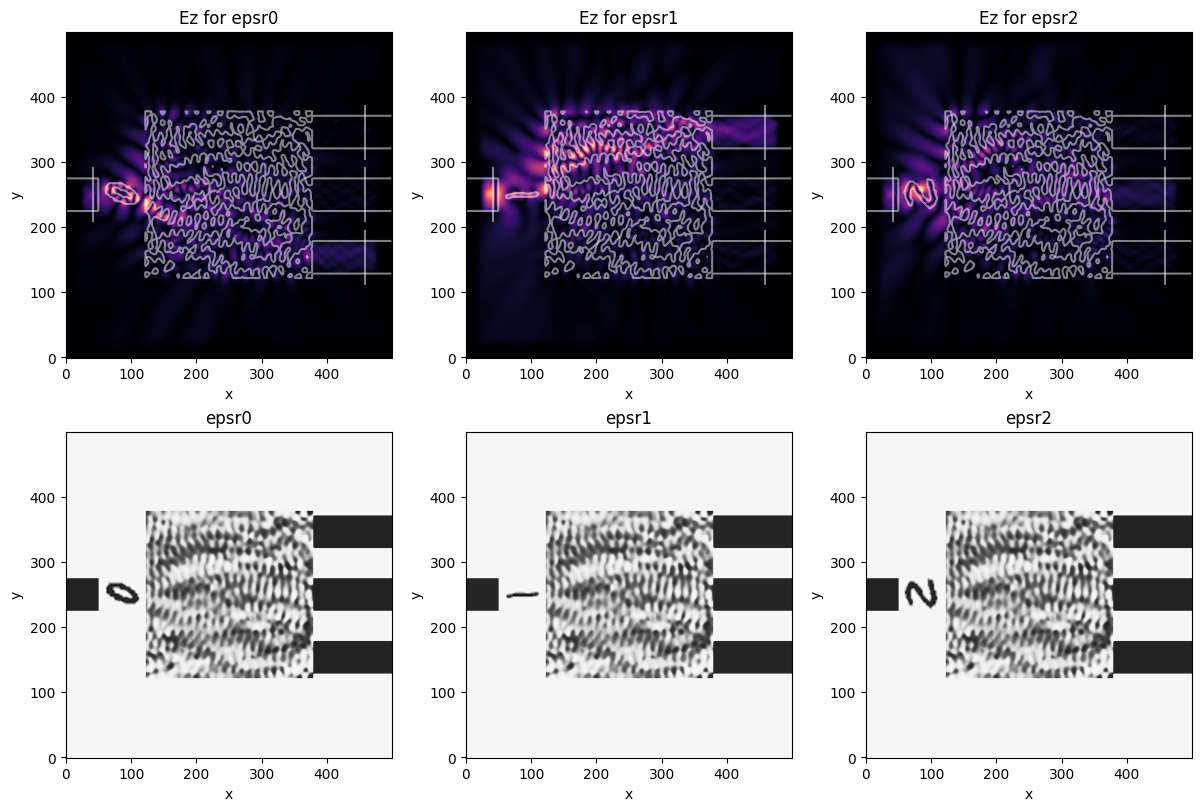

In [ ]:
# Simulate optimal device
rho_optimum = rho_optimum.reshape((Nx, Ny))
epsr0 = epsr_parameterization(rho_optimum, bg_rho0, design_region, \
                              radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)
epsr1 = epsr_parameterization(rho_optimum, bg_rho1, design_region, \
                              radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)
epsr2 = epsr_parameterization(rho_optimum, bg_rho2, design_region, \
                              radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)

(simulation1, simulation2, simulation3, ax, fig) = viz_sim(epsr0, epsr1, epsr2, source0, source1, source2, slices=[input_slice, output_slice1, output_slice2, output_slice3])


In [ ]:
output_slice1

Slice(x=array(459), y=array([113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       191, 192, 193, 194]))

In [ ]:
'''
epsr_back = epsr0
epsr_back[Npml+space-Npixel:Npml+space,Ny//2-Npixel//2:Ny//2+Npixel//2] = epsr_back[0,0]
ceviche.viz.abs(epsr_back, cbar=True);
plt.show()
'''

'\nepsr_back = epsr0\nepsr_back[Npml+space-Npixel:Npml+space,Ny//2-Npixel//2:Ny//2+Npixel//2] = epsr_back[0,0]\nceviche.viz.abs(epsr_back, cbar=True);\nplt.show()\n'

In [ ]:
simulation1 = fdfd_ez(omega1, dl, epsr0, [Npml, Npml])
_, _, Ez1 = simulation1.solve(source0)
simulation2 = fdfd_ez(omega1, dl, epsr1, [Npml, Npml])
_, _, Ez2 = simulation2.solve(source1)
simulation3 = fdfd_ez(omega1, dl, epsr2, [Npml, Npml])
_, _, Ez3 = simulation3.solve(source2)

Text(0.5, 1.0, 'sqrt|Ez| for epsr2')

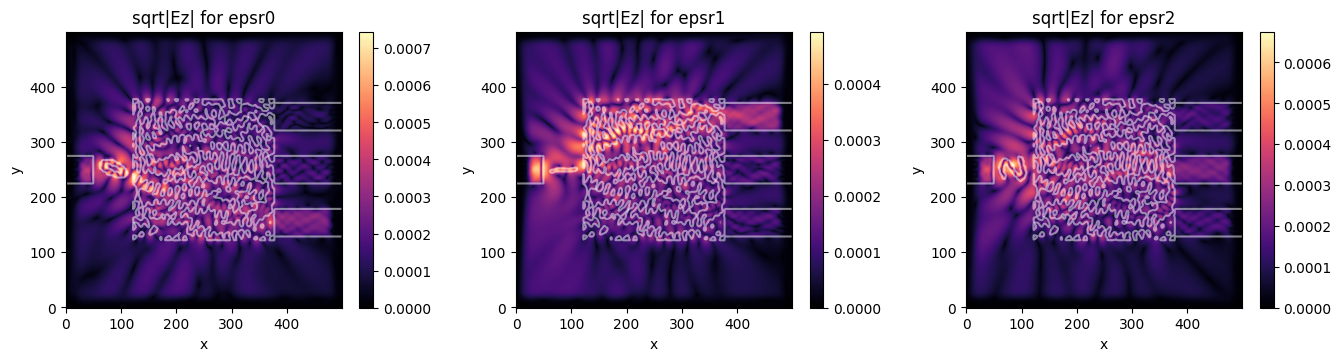

In [ ]:
fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=(13.5, 3.5))
ceviche.viz.abs((np.abs(Ez1))**0.5, outline=epsr0, ax=ax[0], cbar=True)
ceviche.viz.abs((np.abs(Ez2))**0.5, outline=epsr1, ax=ax[1], cbar=True)
ceviche.viz.abs((np.abs(Ez3))**0.5, outline=epsr2, ax=ax[2], cbar=True)
ax[0].set_title('sqrt|Ez| for epsr0')
ax[1].set_title('sqrt|Ez| for epsr1')
ax[2].set_title('sqrt|Ez| for epsr2')

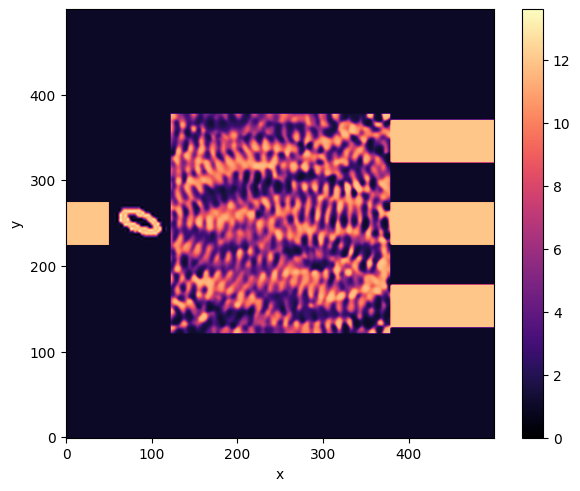

In [ ]:
ax = ceviche.viz.abs(epsr0, cbar=True);
plt.show()

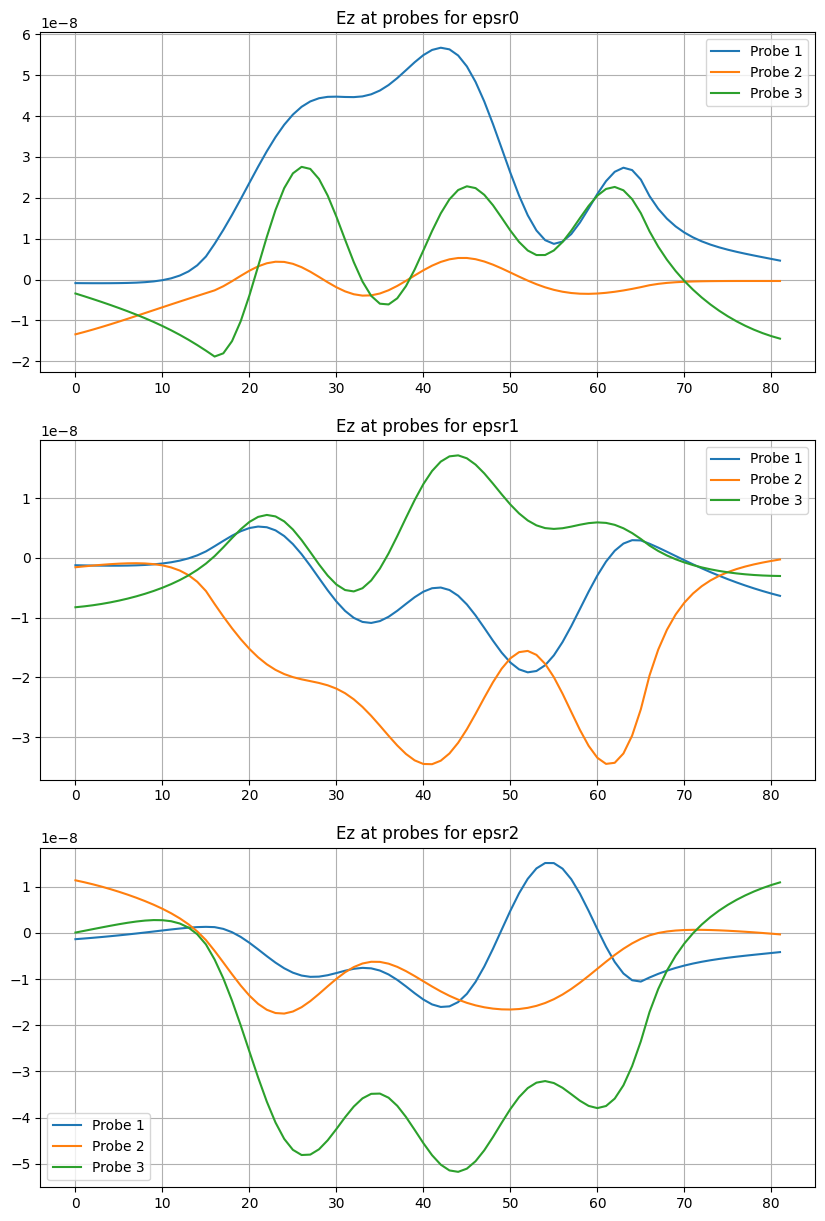

In [ ]:
class Slice:
    def __init__(self, x, y):
        self.x = x
        self.y = y

# Function to extract Ez values at probes
def extract_Ez_at_probes(simulation, slices, source):
    Ez_values = []
    for sl in slices:
        _, _, Ez = simulation.solve(source)
        Ez_values.append(Ez[sl.x, sl.y])
    return Ez_values

# Extract Ez values for each probe
Ez_values0 = extract_Ez_at_probes(simulation1, [output_slice1, output_slice2, output_slice3], source0)
Ez_values1 = extract_Ez_at_probes(simulation2, [output_slice1, output_slice2, output_slice3], source1)
Ez_values2 = extract_Ez_at_probes(simulation3, [output_slice1, output_slice2, output_slice3], source2)

# Plot Ez values for each probe
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

for i, (Ez_values, epsr) in enumerate(zip([Ez_values0, Ez_values1, Ez_values2], [epsr0, epsr1, epsr2])):
    for j, Ez in enumerate(Ez_values):
        axs[i].plot((Ez), label=f'Probe {j+1}')
    axs[i].set_title(f'Ez at probes for epsr{i}')
    axs[i].legend()
    axs[i].grid(True)

plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


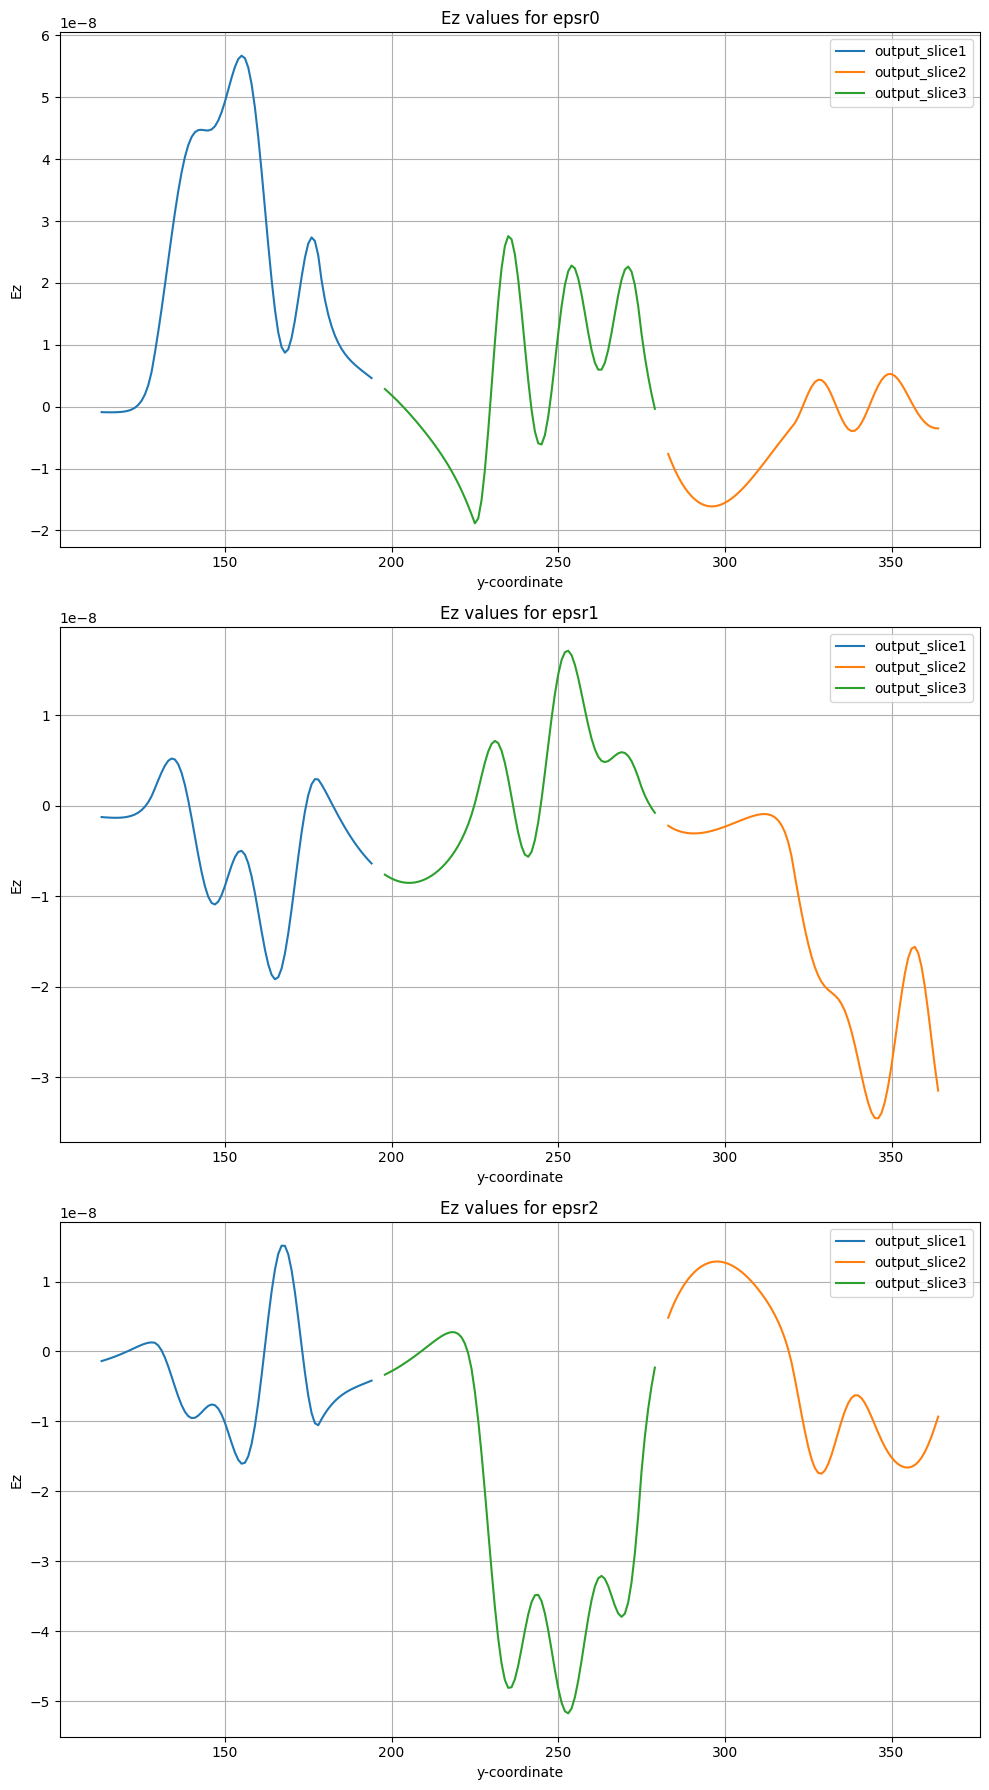

In [ ]:
import matplotlib.pyplot as plt

# Assuming that epsr0, epsr1, epsr2, simulation1, simulation2, simulation3, source0, source1, source2
# are already defined as per your earlier code.

class Slice:
    def __init__(self, x, y):
        self.x = x
        self.y = y

# Define the output slices
output_slice1 = Slice(x=np.array(459), y=np.array([113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
                                                   126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
                                                   139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
                                                   152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
                                                   165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
                                                   178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
                                                   191, 192, 193, 194]))
output_slice2 = Slice(x=np.array(459), y=np.array([283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295,
                                                   296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308,
                                                   309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321,
                                                   322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334,
                                                   335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347,
                                                   348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360,
                                                   361, 362, 363, 364]))
output_slice3 = Slice(x=np.array(459), y=np.array([198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210,
                                                   211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223,
                                                   224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236,
                                                   237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249,
                                                   250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262,
                                                   263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275,
                                                   276, 277, 278, 279]))

def extract_Ez_at_slice(simulation, source, sl):
    _, _, Ez = simulation.solve(source)
    return Ez[sl.x, sl.y]

# Extract Ez values for each slice for each simulation
Ez_values0_slice1 = extract_Ez_at_slice(simulation1, source0, output_slice1)
Ez_values0_slice2 = extract_Ez_at_slice(simulation1, source0, output_slice2)
Ez_values0_slice3 = extract_Ez_at_slice(simulation1, source0, output_slice3)

Ez_values1_slice1 = extract_Ez_at_slice(simulation2, source1, output_slice1)
Ez_values1_slice2 = extract_Ez_at_slice(simulation2, source1, output_slice2)
Ez_values1_slice3 = extract_Ez_at_slice(simulation2, source1, output_slice3)

Ez_values2_slice1 = extract_Ez_at_slice(simulation3, source2, output_slice1)
Ez_values2_slice2 = extract_Ez_at_slice(simulation3, source2, output_slice2)
Ez_values2_slice3 = extract_Ez_at_slice(simulation3, source2, output_slice3)

# Plot Ez values for each epsr in separate graphs
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Plot for epsr0
axs[0].plot(output_slice1.y, Ez_values0_slice1, label='output_slice1')
axs[0].plot(output_slice2.y, Ez_values0_slice2, label='output_slice2')
axs[0].plot(output_slice3.y, Ez_values0_slice3, label='output_slice3')
axs[0].set_xlabel('y-coordinate')
axs[0].set_ylabel('Ez')
axs[0].set_title('Ez values for epsr0')
axs[0].legend()
axs[0].grid(True)

# Plot for epsr1
axs[1].plot(output_slice1.y, Ez_values1_slice1, label='output_slice1')
axs[1].plot(output_slice2.y, Ez_values1_slice2, label='output_slice2')
axs[1].plot(output_slice3.y, Ez_values1_slice3, label='output_slice3')
axs[1].set_xlabel('y-coordinate')
axs[1].set_ylabel('Ez')
axs[1].set_title('Ez values for epsr1')
axs[1].legend()
axs[1].grid(True)

# Plot for epsr2
axs[2].plot(output_slice1.y, Ez_values2_slice1, label='output_slice1')
axs[2].plot(output_slice2.y, Ez_values2_slice2, label='output_slice2')
axs[2].plot(output_slice3.y, Ez_values2_slice3, label='output_slice3')
axs[2].set_xlabel('y-coordinate')
axs[2].set_ylabel('Ez')
axs[2].set_title('Ez values for epsr2')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


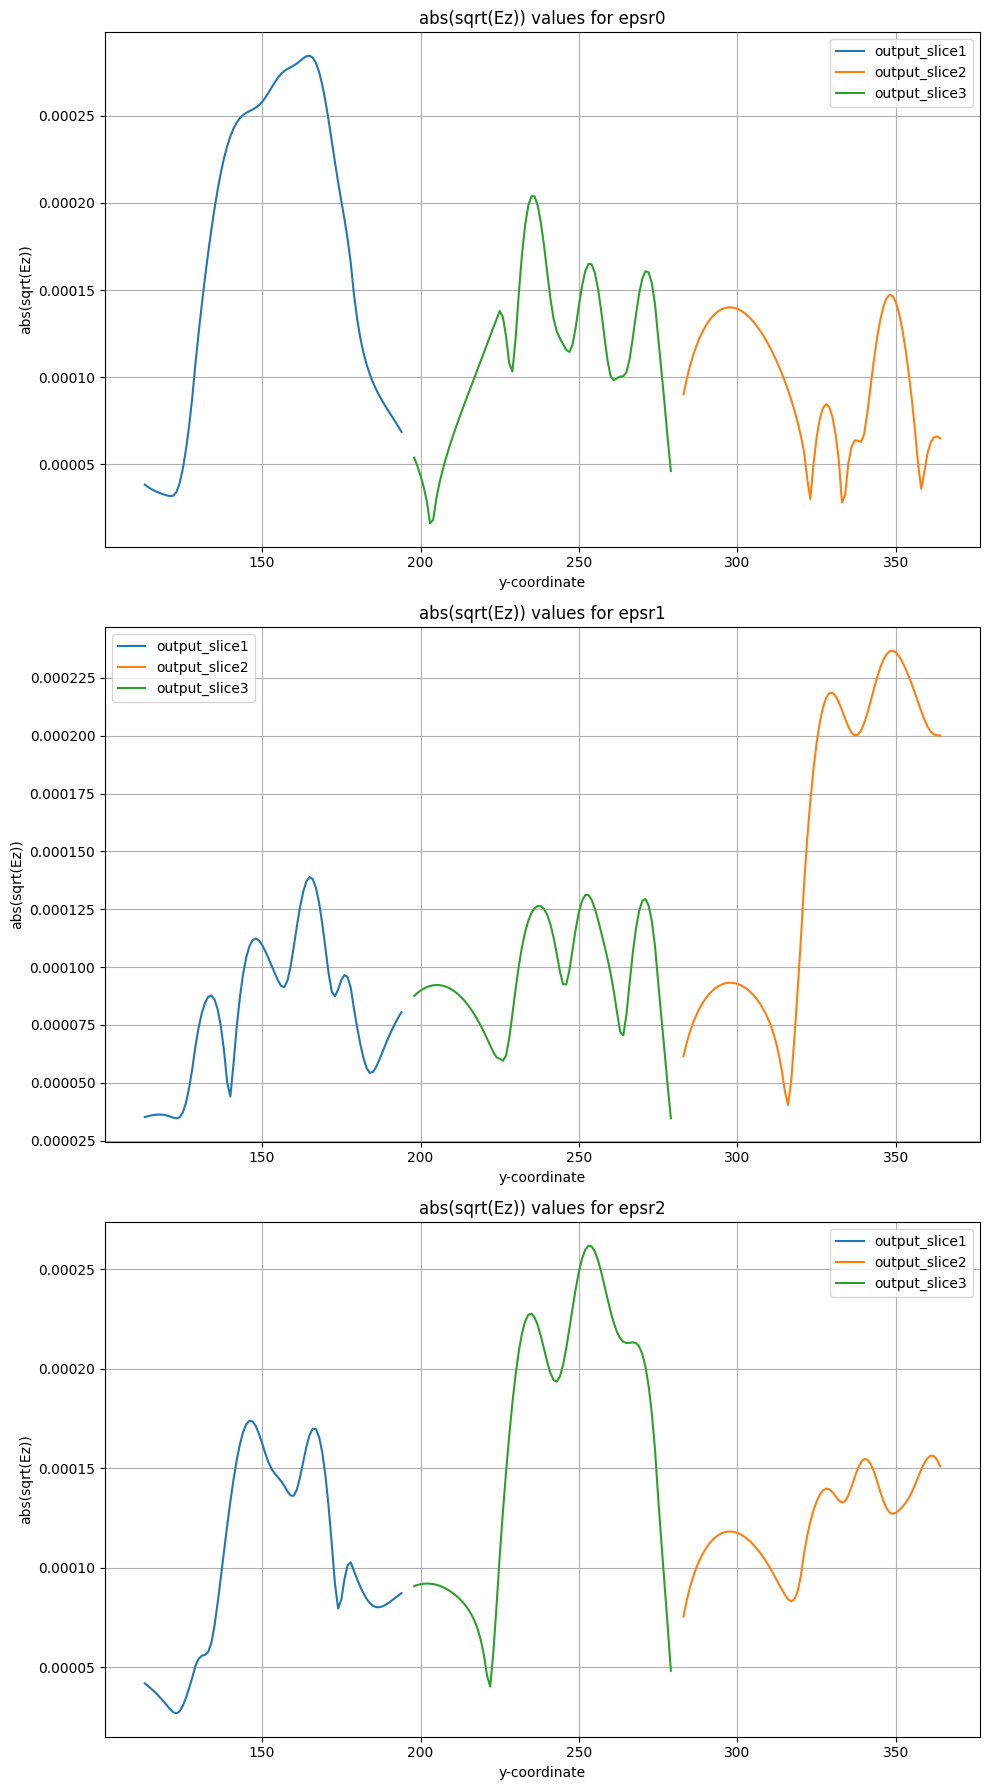

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming that epsr0, epsr1, epsr2, simulation1, simulation2, simulation3, source0, source1, source2
# are already defined as per your earlier code.

class Slice:
    def __init__(self, x, y):
        self.x = x
        self.y = y

# Define the output slices
output_slice1 = Slice(x=np.array(459), y=np.array([113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
                                                   126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
                                                   139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
                                                   152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
                                                   165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
                                                   178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
                                                   191, 192, 193, 194]))
output_slice2 = Slice(x=np.array(459), y=np.array([283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295,
                                                   296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308,
                                                   309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321,
                                                   322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334,
                                                   335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347,
                                                   348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360,
                                                   361, 362, 363, 364]))
output_slice3 = Slice(x=np.array(459), y=np.array([198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210,
                                                   211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223,
                                                   224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236,
                                                   237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249,
                                                   250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262,
                                                   263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275,
                                                   276, 277, 278, 279]))

def extract_Ez_at_slice(simulation, source, sl):
    _, _, Ez = simulation.solve(source)
    return Ez[sl.x, sl.y]

# Extract Ez values for each slice for each simulation
Ez_values0_slice1 = extract_Ez_at_slice(simulation1, source0, output_slice1)
Ez_values0_slice2 = extract_Ez_at_slice(simulation1, source0, output_slice2)
Ez_values0_slice3 = extract_Ez_at_slice(simulation1, source0, output_slice3)

Ez_values1_slice1 = extract_Ez_at_slice(simulation2, source1, output_slice1)
Ez_values1_slice2 = extract_Ez_at_slice(simulation2, source1, output_slice2)
Ez_values1_slice3 = extract_Ez_at_slice(simulation2, source1, output_slice3)

Ez_values2_slice1 = extract_Ez_at_slice(simulation3, source2, output_slice1)
Ez_values2_slice2 = extract_Ez_at_slice(simulation3, source2, output_slice2)
Ez_values2_slice3 = extract_Ez_at_slice(simulation3, source2, output_slice3)

# Calculate abs(sqrt(Ez)) for each slice
Ez_sqrt_abs_values0_slice1 = np.abs(np.sqrt(Ez_values0_slice1))
Ez_sqrt_abs_values0_slice2 = np.abs(np.sqrt(Ez_values0_slice2))
Ez_sqrt_abs_values0_slice3 = np.abs(np.sqrt(Ez_values0_slice3))

Ez_sqrt_abs_values1_slice1 = np.abs(np.sqrt(Ez_values1_slice1))
Ez_sqrt_abs_values1_slice2 = np.abs(np.sqrt(Ez_values1_slice2))
Ez_sqrt_abs_values1_slice3 = np.abs(np.sqrt(Ez_values1_slice3))

Ez_sqrt_abs_values2_slice1 = np.abs(np.sqrt(Ez_values2_slice1))
Ez_sqrt_abs_values2_slice2 = np.abs(np.sqrt(Ez_values2_slice2))
Ez_sqrt_abs_values2_slice3 = np.abs(np.sqrt(Ez_values2_slice3))

# Plot abs(sqrt(Ez)) values for each epsr in separate graphs
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Plot for epsr0
axs[0].plot(output_slice1.y, Ez_sqrt_abs_values0_slice1, label='output_slice1')
axs[0].plot(output_slice2.y, Ez_sqrt_abs_values0_slice2, label='output_slice2')
axs[0].plot(output_slice3.y, Ez_sqrt_abs_values0_slice3, label='output_slice3')
axs[0].set_xlabel('y-coordinate')
axs[0].set_ylabel('abs(sqrt(Ez))')
axs[0].set_title('abs(sqrt(Ez)) values for epsr0')
axs[0].legend()
axs[0].grid(True)

# Plot for epsr1
axs[1].plot(output_slice1.y, Ez_sqrt_abs_values1_slice1, label='output_slice1')
axs[1].plot(output_slice2.y, Ez_sqrt_abs_values1_slice2, label='output_slice2')
axs[1].plot(output_slice3.y, Ez_sqrt_abs_values1_slice3, label='output_slice3')
axs[1].set_xlabel('y-coordinate')
axs[1].set_ylabel('abs(sqrt(Ez))')
axs[1].set_title('abs(sqrt(Ez)) values for epsr1')
axs[1].legend()
axs[1].grid(True)

# Plot for epsr2
axs[2].plot(output_slice1.y, Ez_sqrt_abs_values2_slice1, label='output_slice1')
axs[2].plot(output_slice2.y, Ez_sqrt_abs_values2_slice2, label='output_slice2')
axs[2].plot(output_slice3.y, Ez_sqrt_abs_values2_slice3, label='output_slice3')
axs[2].set_xlabel('y-coordinate')
axs[2].set_ylabel('abs(sqrt(Ez))')
axs[2].set_title('abs(sqrt(Ez)) values for epsr2')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()
